## Importing Data From Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [01:09<00:00, 18.5MB/s]
100% 1.04G/1.04G [01:09<00:00, 16.1MB/s]


In [ ]:
!unzip flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Python Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import string
import joblib
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, add, concatenate, BatchNormalization
from keras.layers import Dense, Embedding, Flatten, Dropout, Activation, LSTM
from keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
"""
Our caption.txt file has 5 captions for each of the image. Now, we are 
creating a dictionary which will have name of the image as key and list of all
the captions as the value of they key...
"""

'\nOur caption.txt file has 5 captions for each of the image. Now, we are \ncreating a dictionary which will have name of the image as key and list of all\nthe captions as the value of they key...\n'

In [ ]:
def map_image_to_captions(captions):
    mapping = {}
    for i in range(len(captions)):
      img = captions.iloc[i]['image'].split('.')[0]
      caption = captions.iloc[i]['caption']
      if(img not in mapping.keys()):
        mapping[img] = [caption]
      else:
        mapping[img].append(caption)
    return mapping

In [ ]:
"""
Now, we are using the function **map_image_to_captions**
to create the dictionary which will have name of the image as key and list of all
the captions as the value of they key...
"""

'\nNow, we are using the function **map_image_to_captions**\nto create the dictionary which will have name of the image as key and list of all\nthe captions as the value of they key...\n'

In [ ]:
captions_file_path = '/content/captions.txt' # path of the **captions.txt** file
captions = pd.read_csv(captions_file_path) # reading the file as pandas dataframe
mappings = map_image_to_captions(captions) # mappings is the name of our dictionary

In [ ]:
"""
Now, I am checking whether the dctionary has been formed
correctly or not...

For that I am checking the captions of this **1009434119_febe49276a.jpg**
image...
"""

'\nNow, I am checking whether the dctionary has been formed\ncorrectly or not...\n\nFor that I am checking the captions of this **1009434119_febe49276a.jpg**\nimage...\n'

In [ ]:
mappings['1009434119_febe49276a']

['A black and white dog is running in a grassy garden surrounded by a white fence .',
 'A black and white dog is running through the grass .',
 'A Boston terrier is running in the grass .',
 'A Boston Terrier is running on lush green grass in front of a white fence .',
 'A dog runs on the green grass near a wooden fence .']

In [ ]:
"""
As we will have to create a vocabulary to feed in the model,
we will have to preprocess the captions...

For that we are removing the punctuations and changing the case
of all the letters to lowercase...

The function to do all these things is written below...
"""

'\nAs we will have to create a vocabulary to feed in the model,\nwe will have to preprocess the captions...\n\nFor that we are removing the punctuations and changing the case\nof all the letters to lowercase...\n\nThe function to do all these things is written below...\n'

In [ ]:
def preprocessing_captions(mappings):
    for key, captions in mappings.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = [letter for letter in caption if letter not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            captions[i] = caption

preprocessing_captions(mappings)

In [ ]:
# mapping after preprocessing captions

mappings['1009434119_febe49276a']

['black and white dog is running in grassy garden surrounded by white fence',
 'black and white dog is running through the grass',
 'boston terrier is running in the grass',
 'boston terrier is running on lush green grass in front of white fence',
 'dog runs on the green grass near wooden fence']

In [ ]:
images = os.listdir('/content/Images/') # this is the list of all the training images we have in our dataset

In [ ]:
images[:5] # printing the name of first five images

['2584020755_14e2b3e8fc.jpg',
 '3138562460_44227a35cf.jpg',
 '3162045919_c2decbb69b.jpg',
 '2147199188_d2d70b88ec.jpg',
 '2744321686_8811d8428c.jpg']

In [ ]:
# function to add start and end sequence symbol to
# each caption, such that the images are present in
# the dataset...

def add_start_and_end_sequence_symbol(mappings):
    final_mappings = {}
    for img, captions in mappings.items():
        if img+'.jpg' in images:
            if img not in final_mappings:
                final_mappings[img] = []
            for line in captions:
                caption = '<start> ' + line + ' <end>'
                final_mappings[img].append(caption)
    return final_mappings
  
final_mappings = add_start_and_end_sequence_symbol(mappings)

In [ ]:
# checking the mapping after adding the <start>
# and <end> symbol...

final_mappings['1009434119_febe49276a']

['<start> black and white dog is running in grassy garden surrounded by white fence <end>',
 '<start> black and white dog is running through the grass <end>',
 '<start> boston terrier is running in the grass <end>',
 '<start> boston terrier is running on lush green grass in front of white fence <end>',
 '<start> dog runs on the green grass near wooden fence <end>']

## Encoding Images using InceptionV3 Pre-Trained Model

In [ ]:
"""
We are using InceptionV3 model for getting the encoding of
images...

This model expects, input images should have
size 299 * 299 * 3...

So for this we will have to preprocess the images...
"""

'\nWe are using InceptionV3 model for getting the encoding of\nimages...\n\nThis model expects, input images should have\nsize 299 * 299 * 3...\n\nSo for this we will have to preprocess the images...\n'

In [ ]:
pre_trained_model = InceptionV3(weights = 'imagenet')
encoder = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.layers[-2].output)

96112376/96112376 [==============================] - 7s 0us/step


In [ ]:
def preprocessing_for_inceptionv3(path):
    img = load_img(os.path.join('/content/Images/',path), target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    return img

In [ ]:
def encode(image):
    image = preprocessing_for_inceptionv3(image)
    image = encoder.predict(image)
    image = image.reshape((image.shape[1],))
    return image

In [ ]:
# Let's encode all the images
# of our dataset...
encodings = {}
for img in images:
    encodings[img] = encode(img)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step


In [ ]:
# storing the encodings of all the images
# for future use...

joblib.dump(encodings,'encodings.pkl')

['encodings.pkl']

In [ ]:
encodings=joblib.load('/content/drive/MyDrive/nlp/encodings.pkl')

## Building Vocabulary

In [ ]:
word2ind = {} # word -> index
ind2word = {} # index -> word

In [ ]:
# List of all the captions

captions = []
for img, its_captions in final_mappings.items():
	for caption in its_captions:
		captions.append(caption)

In [ ]:
# printing first 10 captions from
# all the availabe captions...

captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tricolored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [ ]:
counts = {}
for caption in captions:
	for word in caption.split(' '):
		counts[word] = counts.get(word, 0) + 1
    
# keeping only those words which occurs atleast 5 times

vocabulary = [word for word in counts if counts[word] >= 5]

ind = 0

for word in vocabulary:
	word2ind[word] = ind
	ind2word[ind] = word
	ind += 1
	
# getting the size of the largest caption
largest_caption_size = max(len(caption.split()) for caption in captions)

In [ ]:
print(f'The size of the largest caption is: {largest_caption_size}')

The size of the largest caption is: 34


## Preparing Input and Output Data

In [ ]:
inp1 = []
inp2 = []
out = []

In [ ]:
for img, captions in final_mappings.items():
	encoding = encodings[img+'.jpg']
	for caption in captions:
		seq = [word2ind[word] for word in caption.split(' ') if word in word2ind]
		for i in range(1, len(seq)):
			input_seq, next_word = seq[:i], seq[i]
			input_seq = pad_sequences([input_seq], maxlen = largest_caption_size)[0]
			next_word = to_categorical([next_word], num_classes = len(vocabulary))[0]
			inp1.append(encoding)
			inp2.append(input_seq)
			out.append(next_word)    

In [ ]:
inp1 = np.array(inp1)
inp2 = np.array(inp2)
out = np.array(out)

In [ ]:
joblib.dump(inp1,'inp1.pkl')
joblib.dump(inp2,'inp2.pkl')
joblib.dump(out,'out.pkl')

['out.pkl']

In [ ]:
"""
Using **glove.6B.200d.txt** file to create
embeddings of 200 dimension...
"""

golve_file ='/content/drive/MyDrive/nlp/glove.6B.200d.txt'

In [ ]:
embeddings = {}
emb_dim = 200

glove = open(golve_file, 'r', encoding = 'utf-8')
glove_data = glove.read()
glove_data = glove_data.split('\n')

for line in glove_data:
	values = line.split(" ")
	word = values[0]
	vals = np.asarray(values[1: ], dtype = 'float32')
	embeddings[word] = vals

embedding_matrix = np.zeros((len(vocabulary), emb_dim))

for word, ind in word2ind.items():
	embedding = embeddings.get(word)
	if embedding is not None:
		embedding_matrix[ind] = embedding

## LSTM Model

In [ ]:
# Model Architecture
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (largest_caption_size, ))
se1 = Embedding(len(vocabulary), emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(len(vocabulary), activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.fit([inp1, inp2], out, epochs = 25, batch_size = 256)

Epoch 1/25
1578/1578 [==============================] - 131s 79ms/step - loss: 3.9639 - accuracy: 0.2672
Epoch 2/25
1578/1578 [==============================] - 124s 79ms/step - loss: 3.2108 - accuracy: 0.3284
Epoch 3/25
1578/1578 [==============================] - 125s 79ms/step - loss: 2.9644 - accuracy: 0.3492
Epoch 4/25
1578/1578 [==============================] - 123s 78ms/step - loss: 2.8093 - accuracy: 0.3659
Epoch 5/25
1578/1578 [==============================] - 123s 78ms/step - loss: 2.6941 - accuracy: 0.3777
Epoch 6/25
1578/1578 [==============================] - 122s 78ms/step - loss: 2.6036 - accuracy: 0.3870
Epoch 7/25
1578/1578 [==============================] - 123s 78ms/step - loss: 2.5279 - accuracy: 0.3967
Epoch 8/25
1578/1578 [==============================] - 122s 77ms/step - loss: 2.4672 - accuracy: 0.4036
Epoch 9/25
1578/1578 [==============================] - 122s 77ms/step - loss: 2.4144 - accuracy: 0.4102
Epoch 10/25
1578/1578 [==============================] 

In [ ]:
model.save('caption_generator.h5')

## Predictions

In [ ]:
def generate_caption(encoding):
	sequence = '<start>'
	for i in range(largest_caption_size):
		seq = [word2ind[word] for word in sequence.split() if word in word2ind]
		seq = pad_sequences([seq], maxlen = largest_caption_size)[0]
		seq = seq.reshape(1,len(seq))
		pred = model.predict([encoding, seq])
		pred = np.argmax(pred)
		word = ind2word[pred]
		sequence += ' ' + word
		if word == '<end>':
			break
	sequence = sequence.split(' ')
	sequence = sequence[1:-1]
	sequence = ' '.join(sequence)
	return sequence

In [ ]:
encoding = encodings['2098418613_85a0c9afea.jpg'].reshape(1,2048)

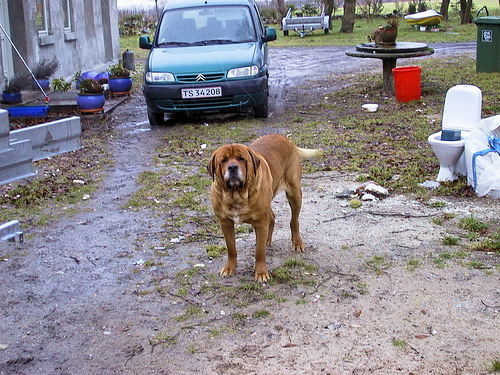

In [ ]:
import cv2
cv2_imshow(cv2.imread('/content/Images/2098418613_85a0c9afea.jpg'))

In [ ]:
generate_caption(encoding)

1/1 [==============================] - 0s 21ms/step


'brown dog is standing in the middle of the water'